# 複数カメラから、距離マップをリアルタイム取得する


In [1]:
from uikit.ui_uiview import *

# 画面サイズを取得する
size = get_screen_bounds().size
# プレビュー表示用のUIViewを作成する
ui_view = create_uiview(
    rect=CGRect(CGPoint(size.width/4/2,size.height/4/2),
                CGSize(3*size.width/4, 3*size.height/4)),
    name='sample',
    color=UIColor.color(red=0,green=0,blue=0,alpha=1)
)

In [2]:
import copy

# 色画像・距離画像を入れるリストを用意
video_and_depths = []

# numpyアレイとしてカメラ画像が渡されると
# リストに追加する
def process_image( video_and_depth ):
        video_and_depths.append({
        "video":copy.copy(video_and_depth['video']),
        "depth":copy.copy(video_and_depth['depth'])})

In [3]:
# ビデオ画像のリアルタイム取得を行うためのモジュール
from avfoundation.video_capture_ex import *

# 撮影用クラスを作る
AVCaptureVideoCaptureEx_ = AVCaptureVideoCaptureEx(
    # 取得デバイス(超広角と広角カメラを組み合わせる)
    AVCaptureDeviceTypeBuiltInDualWideCamera,
    # カメラ位置
    AVCaptureDevicePositionBack,
    # 取得画像サイズ
    'AVCaptureSessionPreset640x480',
    # 画像色フォーマット    
    CV32BGRA,
    # 取得画像を使った処理を行うユーザ関数
    process_image,           
    # UIViewへの表示画像を生成するユーザ関数
    None,                   
    # 取得画像を表示するUIView
    ui_view)

In [4]:
import time

# 撮影開始
AVCaptureVideoCaptureEx_.video_shooting_start(0.1) # 撮影インターバルを秒で指定
time.sleep(2) # 2秒間にわたり撮影を行う
# 撮影を終了する
AVCaptureVideoCaptureEx_.video_shooting_close(ui_view)

processed_frames:21


In [6]:
l = len(video_and_depths)         # 取得した画像の枚数
print("{:d} images are captured.".format(l))

 # 取得した画像の縦・横サイズ
video_h, video_w = video_and_depths[0]['video'].shape 
print(
  "image: height:{:d} pixels x width:{:d} pixels".format(
      video_h, video_w))

# 取得した画像の縦・横サイズ
depth_h, depth_w = video_and_depths[0]['depth'].shape 
print(
  "depth: height:{:d} pixels x width:{:d} pixels".format(
      depth_h, depth_w))

15 images are captured.
image: height:640 pixels x width:1920 pixels
depth: height:240 pixels x width:320 pixels


<Figure size 600x600 with 0 Axes>

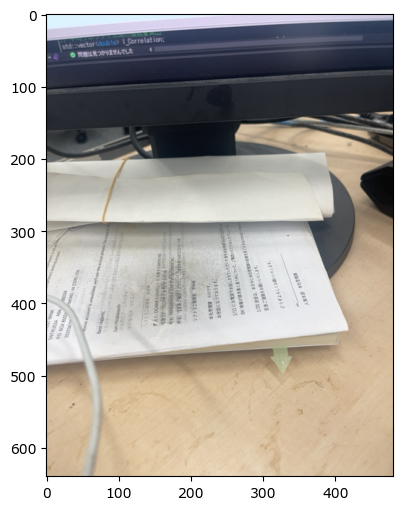

In [7]:
# matplotlibを使って画像を表示する
from matplotlib import pylab as plt
import cv2

plt.figure(figsize=[6,6])

# 色順をBGRAからRGBAに変える
rgba_image = cv2.cvtColor( 
    video_and_depths[0]['video'].reshape(
        video_h, int(video_w/4), 4), 
    cv2.COLOR_BGRA2RGBA)

# 色画像を表示する
plt.figure(figsize=[6,6])
plt.imshow(rgba_image)

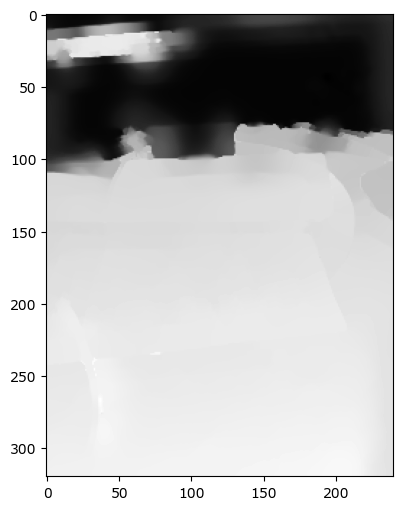

In [8]:
# 距離マップ画像を表示する
plt.figure(figsize=[6,6])

# カラーマップはグレイレベルを指定する
plt.imshow(
    # 撮影時姿勢に合うように回転させる
    np.rot90(video_and_depths[0]['depth'], 3),
    cmap='gray')

(256, 256, 3)


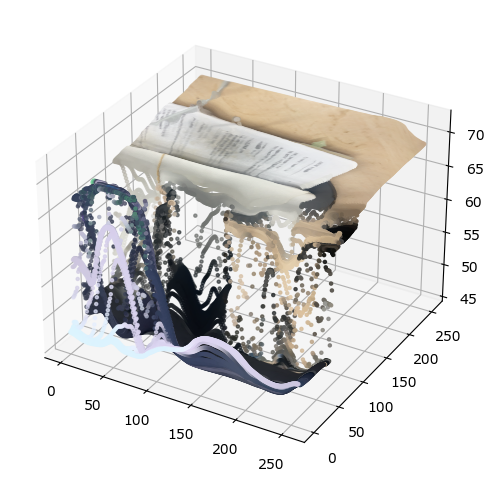

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from itertools import chain

# コメントアウトしなければ、インタラクティブに動かせる
#%matplotlib notebook

# 散布データのサイズを指定する
l=256
size=(l,l)

# テクスチャ画像を作る
tex = cv2.resize(rgba_image/255, size)[:,:,:3]
print(tex.shape)

# 高さ画像を作る
z = np.rot90(np.array(video_and_depths[0]['depth'])/255,3)
zz = cv2.resize(z, size)

# 散布データを作る
x = y = np.linspace(0, l, l)
xx, yy = np.meshgrid(x, y)

# 散布図として表示する
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(np.ravel(xx), np.ravel(yy), np.ravel(zz), 
             marker='.',c=np.reshape(tex,(l*l,3))) 
# 見やすさのために、必要に応じて軸反転などをする
#ax.invert_zaxis()
plt.show()

In [ ]:
!pip install k3d

In [78]:
import k3d
import numpy as np

def rgb_to_hex(rgb):
    return int(rgb[0]*255)*256*256+int(rgb[1]*255)*256+int(rgb[2]*255)

_y = np.ravel(yy)
_x = np.ravel(xx)
_z = np.ravel(zz)
_c=np.reshape(tex,(l*l,3))

pos=[]
col=[]
for i, z in enumerate(_z):
    # 座標を設定する
    pos.append(
        [_x[i], _y[i], 10*_z[i]]) 
    # 色を設定する
    col.append(rgb_to_hex(_c[i]))

In [79]:
# ３次元点群を生成する
plt_points = k3d.points(
    positions=pos[::2],
    colors=np.array(col[::2]),
    point_size=3,
    shader='3d')
plot = k3d.plot()
plot += plt_points
plot.display()

Output()

In [ ]:
!pip install trimesh

In [82]:
import trimesh

points = np.random.random((100, 3))
pts = trimesh.points.PointCloud( vertices=pos, colors=_c )
# 表示させたければ
#pts.show()
pts.export("pts.ply");